# Chord Recognition


## Setting up Environment
```bash
$ python -m venv chord
$ source chord/bin/activate # for linux
$ ./chord/Scripts/activate # for windows
$ python.exe -m pip install --upgrade pip # upgrade pip
$ pip install -r requirements.txt
```

In [163]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import scipy
import librosa
import soundfile as sf
import IPython.display as ipd
import pandas as pd
import os

import libfmp.b
import libfmp.c3
import libfmp.c4

# Import src
from src import templateMatch as tm
from src import hiddenMarModel as hmm
from src import filtering as filter

## Template Based Chord Recognition

(12, 24)


(None,
 [<Axes: title={'center': 'Chord Templates'}, xlabel='Chroma', ylabel='Chord'>],
 <matplotlib.image.AxesImage at 0x7cf3dd1a2e60>)

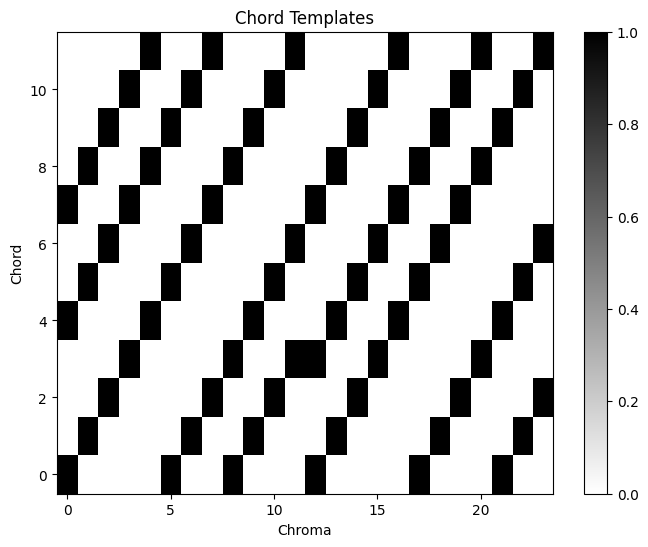

In [164]:
template = tm.generate_chord_templates()
print(template.shape)
# Plot 
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
libfmp.b.plot_matrix(template, ax=[ax], xlabel='Chroma', ylabel='Chord', title='Chord Templates', clim=[0, 1])


In [ ]:
# Compute chroma features
# anti_hero_chord_progression.wave: Amaj, Emaj, Bmaj, C#maj
fn_wav = 'resources/piano/antihero_chord_progression.wav'

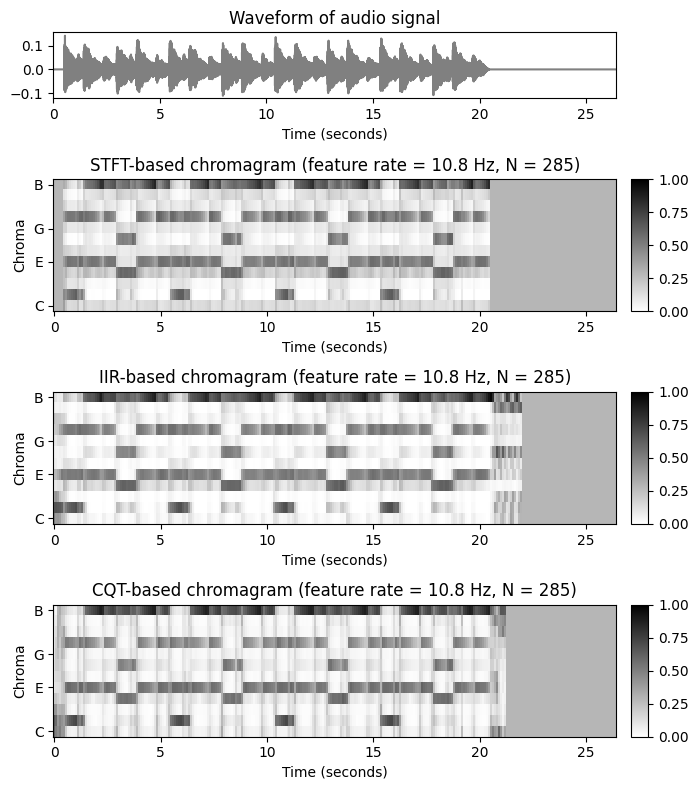

In [166]:
N = 4096
H = 2048
X_STFT, Fs_X, x, Fs, x_dur = tm.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
X_IIR, Fs_X, x, Fs, x_dur = tm.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=100, version='IIR')
X_CQT, Fs_X, x, Fs, x_dur = tm.compute_chromagram_from_filename(fn_wav, N=N, H=H, version='CQT')

# Plot
cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 2, 2, 2]}, figsize=(7, 8))
libfmp.b.plot_signal(x, Fs, ax=ax[0,0], title='Waveform of audio signal')

ax[0,1].axis('off')
title = 'STFT-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_STFT.shape[1])
tm.plot_chromagram_annotation([ax[1, 0], ax[1, 1]], X_STFT, Fs_X, ann=None, color_ann=None, x_dur=None, title=title)

title = 'IIR-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_IIR.shape[1])
tm.plot_chromagram_annotation([ax[2, 0], ax[2, 1]], X_IIR, Fs_X, title=title)

title = 'CQT-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_CQT.shape[1])
tm.plot_chromagram_annotation([ax[3, 0], ax[3, 1]], X_CQT, Fs_X, title=title)

plt.tight_layout()

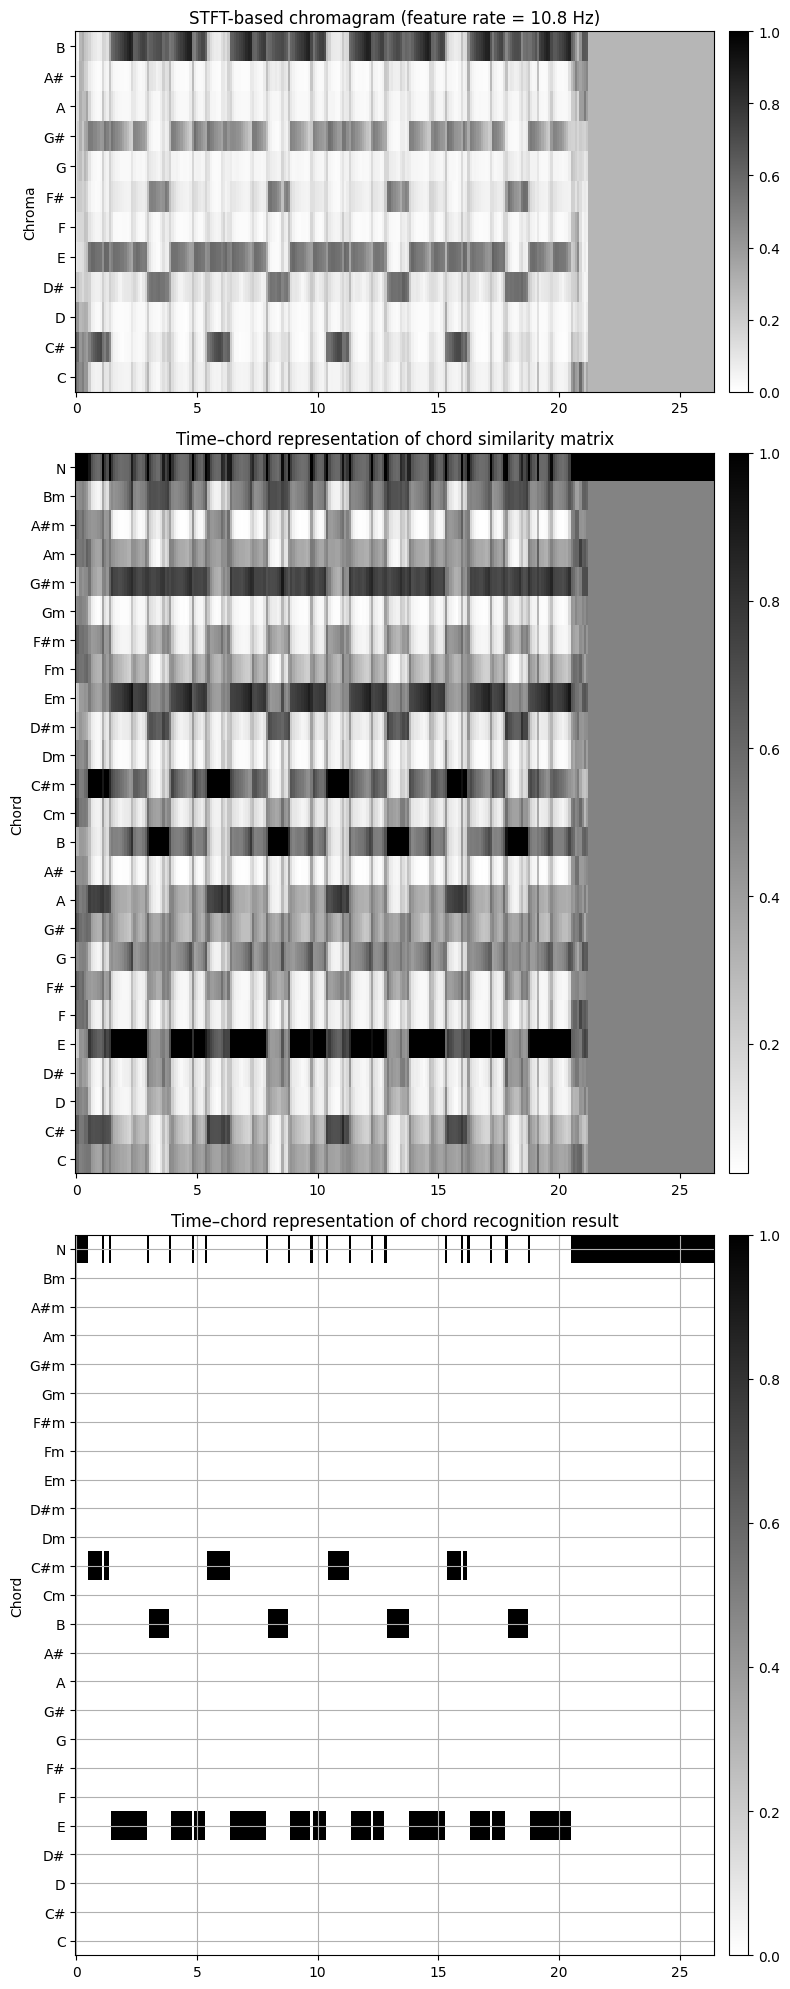

In [167]:
# Chord recognition
X = X_CQT
chord_sim, chord_max = tm.chord_recognition_template(X,nonchord=True, norm_sim='max')
chord_labels = tm.get_chord_labels(nonchord=True)

# Plot
cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1.5, 3, 3]}, figsize=(8, 20))
libfmp.b.plot_chromagram(X, ax=[ax[0,0], ax[0,1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))

libfmp.b.plot_matrix(chord_sim, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord similarity matrix',
                     ylabel='Chord', xlabel='')
ax[1, 0].set_yticks(np.arange( len(chord_labels) ))
ax[1, 0].set_yticklabels(chord_labels)

libfmp.b.plot_matrix(chord_max, ax=[ax[2, 0], ax[2, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord recognition result',
                     ylabel='Chord', xlabel='')
ax[2, 0].set_yticks(np.arange( len(chord_labels) ))
ax[2, 0].set_yticklabels(chord_labels)
ax[2, 0].grid()
plt.tight_layout()
        

# Hidden Markov Model
We will estimate the state transition matrix $A$ using datasets, which helps simplify our implementation, which use Viterbi alogirthm to 'uncover' the chords.

Parameters:
- $A$: State Transition Matrix, estimated using annotated dataset
- $C$: Initial State Matrix, use uniform distribution
- $B$: Emission Matrix, use normalized Chroma vector which also used for Template Matching
- $O$: Observation Sequence, from the Chroma Features

### 1st Step: Estimate $A$
Using the Dataset, counting all bigrams $\{\text{State}[i], \text{State}[i+1]\}$, then normalize it.

In [168]:
# Counting bigram for all of the .csv
# For each dataset, load the chord labels, simplify the chord labels, and count the bigrams
# Create a dictionary to store the bigram counts
bigram_counts = {}
unique_chords = set()

# Loop through the dataset
for file in os.listdir('dataset'):
    # Load the chord labels
    if 'whitespace' in file:
        chord_labels = hmm.load_chord_labels('dataset/' + file, sep=' ')
    else:
        # continue
        chord_labels = hmm.load_chord_labels('dataset/' + file)
    
    # Simplify the chord labels
    chord_labels['chord'] = chord_labels['chord'].apply(lambda x : hmm.simplify_chords(x))

    # Enharmoic compensation
    chord_labels['chord'] = chord_labels['chord'].apply(lambda x: hmm.enharmonic_compensation(x))
    debug = chord_labels['chord']
    
    # Update the set of unique chords
    unique_chords.update(chord_labels['chord'])
    
    # Create an array listing chord progression according to the chord labels
    array_chords = chord_labels['chord'].to_numpy()
    
    # Count the bigrams
    bigram_counts[file] = hmm.bigram_counting(array_chords)

# Combine the bigram counts across all datasets
bigram_counts_all = {}
for bigram_count in bigram_counts.values():
    for bigram, count in bigram_count.items():
        if bigram in bigram_counts_all:
            bigram_counts_all[bigram] += count
        else:
            bigram_counts_all[bigram] = count

<Figure size 1200x1200 with 0 Axes>

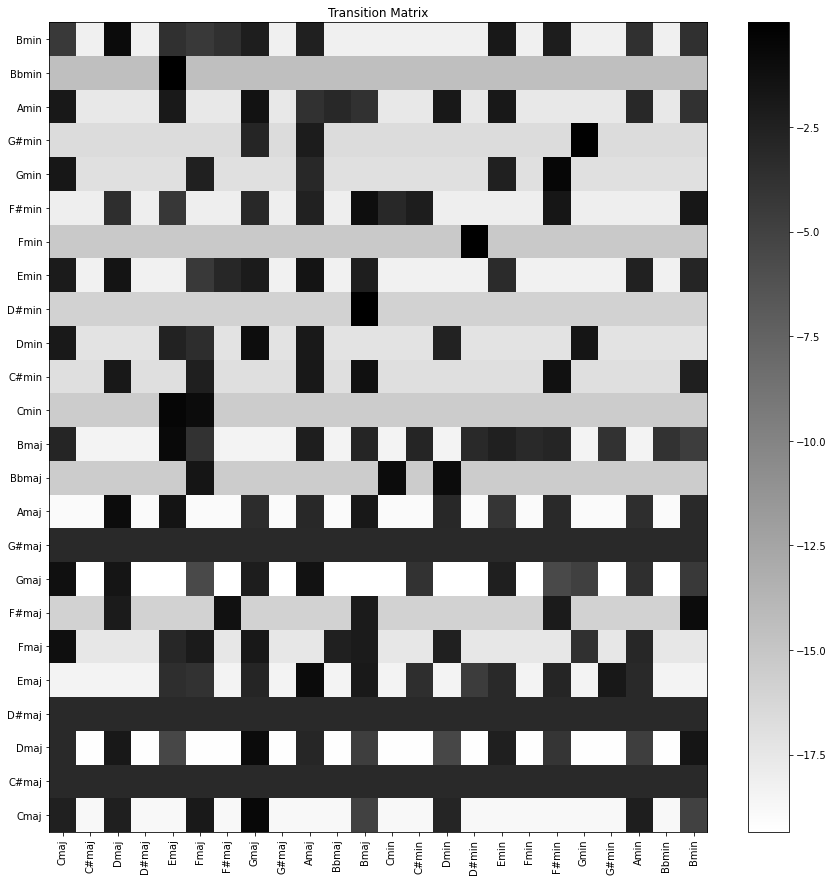

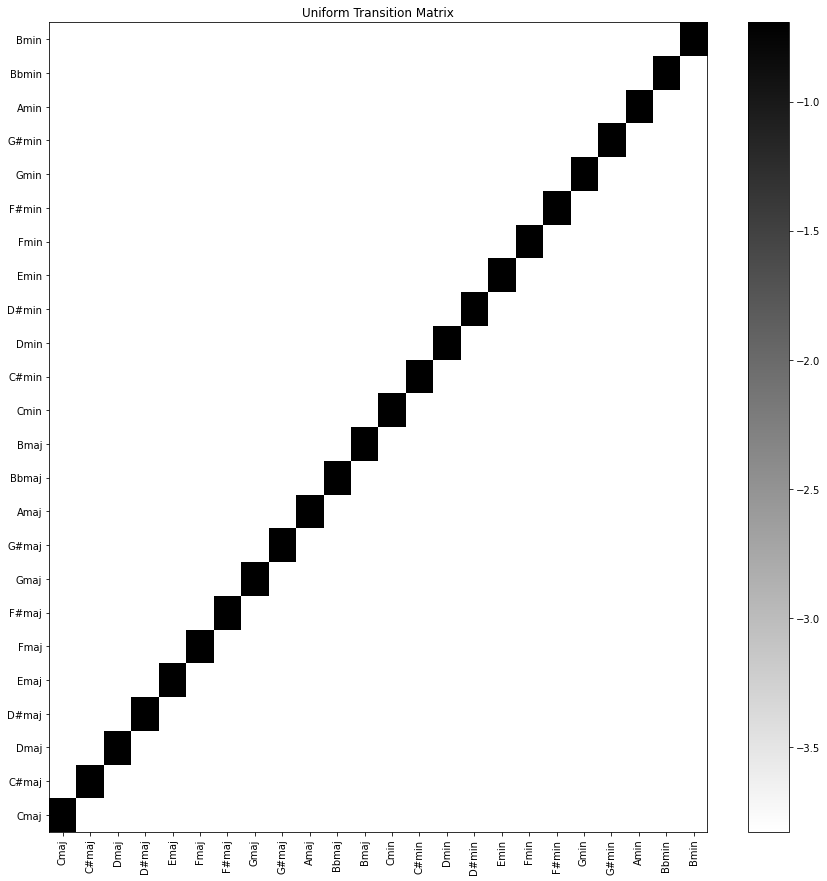

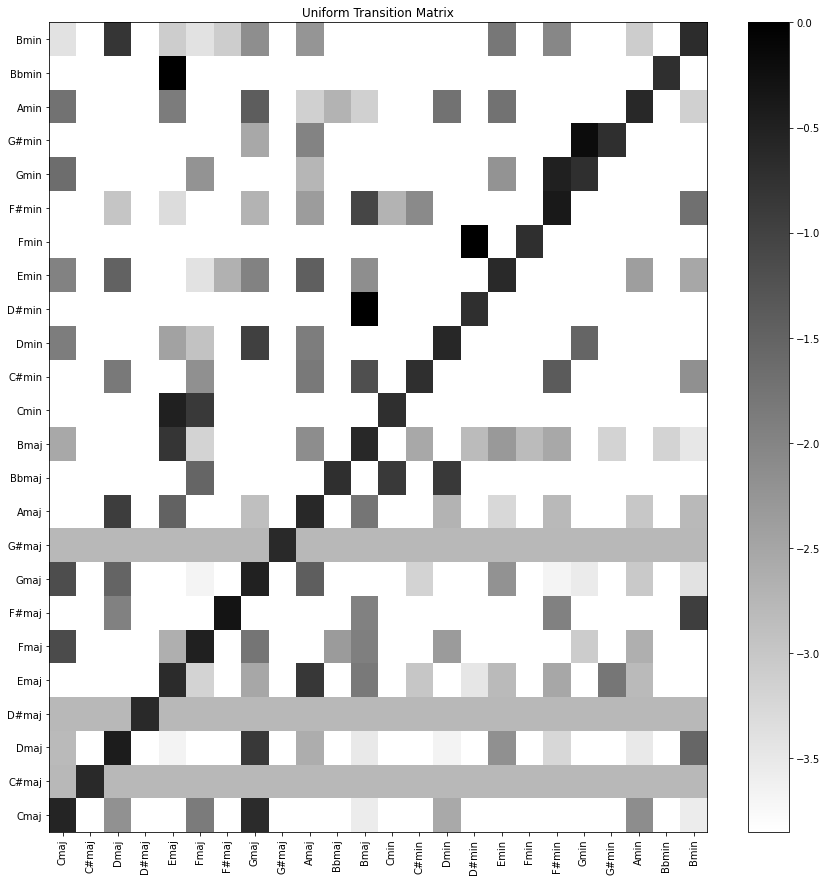

In [169]:
# Summarize into Matrix A

# Create a list of unique chords
# print(unique_chords)

# Codebook that maps each chord to an index
chord_24 = ['Cmaj', 'C#maj', 'Dmaj', 'D#maj', 'Emaj', 'Fmaj', 'F#maj', 'Gmaj', 'G#maj', 'Amaj', 'Bbmaj', 'Bmaj', 'Cmin', 'C#min', 'Dmin', 'D#min', 'Emin', 'Fmin', 'F#min', 'Gmin', 'G#min', 'Amin', 'Bbmin', 'Bmin']

codebook = {chord: i for i, chord in enumerate(chord_24)}

# Create a transition matrix
# Initialize the transition matrix with epsilon to avoid zero probabilities
A = np.ones((24, 24)) * 1e-6

# Loop through the bigram_counts_all to populate the transition matrix
for bigram, count in bigram_counts_all.items():
    i = codebook[bigram[0]]
    j = codebook[bigram[1]]
    A[i, j] = count

# Normalize the transition matrix
A = A / np.sum(A, axis=1)[:, np.newaxis]

# Plot the transition matrix
plt.figure(figsize=(12, 12))
libfmp.b.plot_matrix(np.log(A), colorbar=True,xlabel=None, ylabel=None,
                      title='Transition Matrix', figsize=(12, 12))
plt.xticks(np.arange(24), chord_24, rotation=90)
plt.yticks(np.arange(24), chord_24)

# Create a uniform transition matrix
A_uni = hmm.uniform_transition_matrix(0.5)
libfmp.b.plot_matrix(np.log(A_uni), colorbar=True,xlabel=None,
                     ylabel=None, title='Uniform Transition Matrix', figsize=(12, 12))

plt.xticks(np.arange(24), chord_24, rotation=90)
plt.yticks(np.arange(24), chord_24)

# Combing the transition matrix and uniform matrix
A_comb = (A + A_uni)
A_comb = A_comb / np.max(A_comb) 
libfmp.b.plot_matrix(np.log(A_comb),colorbar=True,xlabel=None,
                     ylabel=None, title='Uniform Transition Matrix', figsize=(12, 12))

plt.xticks(np.arange(24), chord_24, rotation=90)
plt.yticks(np.arange(24), chord_24)
plt.show()

### 2nd Step: Implement Viterbi 

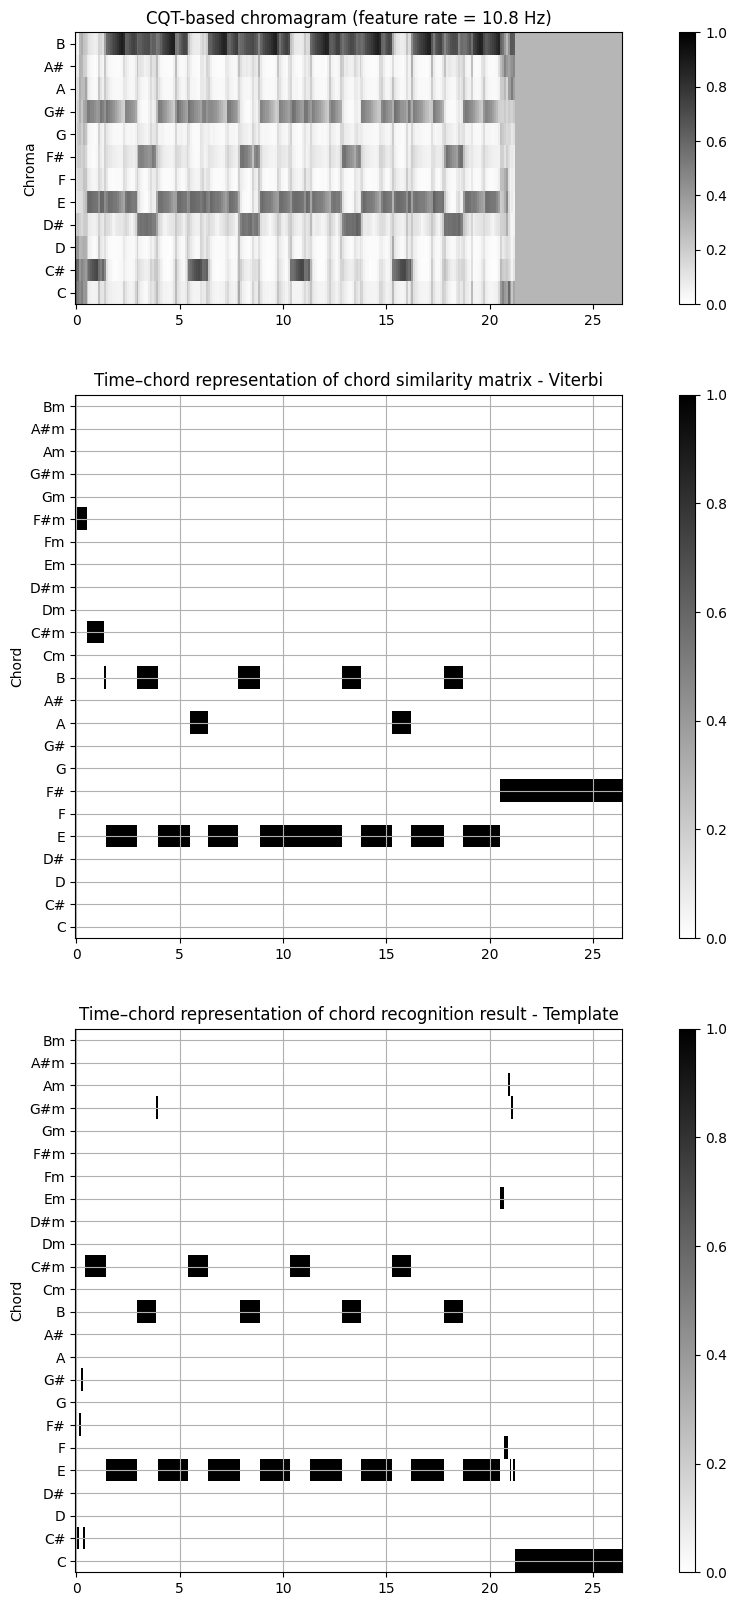

In [180]:
A_in = A_comb
B_O, _ = tm.chord_recognition_template(X,nonchord=False, norm_sim='max')
C = 1/24 * np.ones((1,24))

chord_viterbi, _, _, _ = hmm.viterbi_log_likelihood(A_in, B_O=B_O, C=C)
## Plot Results ##

chord_labels_hmm = tm.get_chord_labels(nonchord=False)

fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1.5, 3, 3]}, figsize=(8, 20))
libfmp.b.plot_chromagram(X, ax=[ax[0,0], ax[0,1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='CQT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))

libfmp.b.plot_matrix(chord_viterbi, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord similarity matrix - Viterbi',
                     ylabel='Chord', xlabel='')
ax[1, 0].set_yticks(np.arange( len(chord_labels_hmm) ))
ax[1, 0].set_yticklabels(chord_labels_hmm)
ax[1, 0].grid()

libfmp.b.plot_matrix(chord_max, ax=[ax[2, 0], ax[2, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord recognition result - Template',
                     ylabel='Chord', xlabel='')
ax[2, 0].set_yticks(np.arange( len(chord_labels_hmm) ))
ax[2, 0].set_yticklabels(chord_labels_hmm)
ax[2, 0].grid()
plt.show()



## Pre/Post Filtering
Applying prefiltering through temporal may increase performance in certain cases

22050
(582650,)


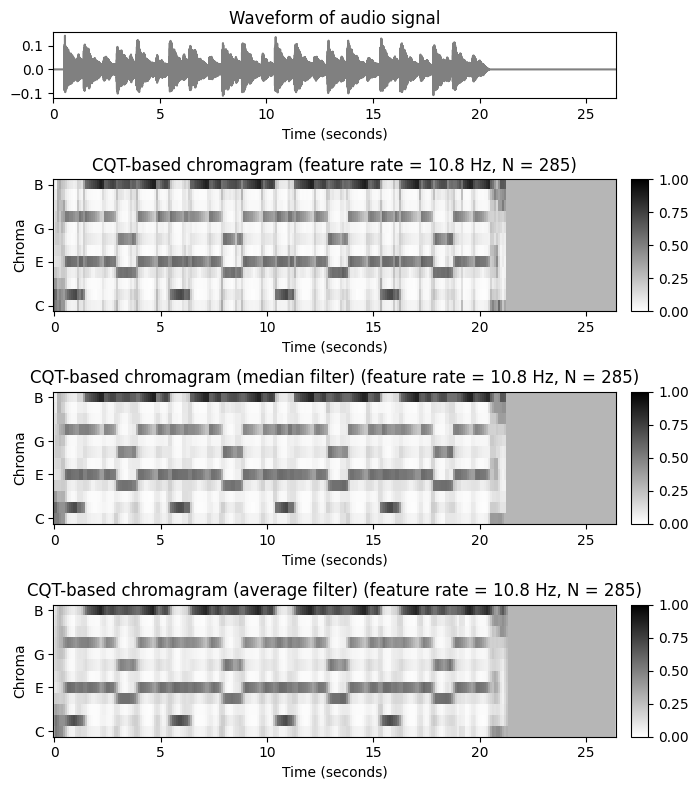

In [171]:
# Load audio file
fn_wav_filt = 'resources/piano/antihero.mp3'
ipd.Audio(fn_wav_filt)
print(fs)
print(x.shape)

N_filt = 4096
H_filt = 2048

X_STFT, Fs_X, x, Fs, x_dur = tm.compute_chromagram_from_filename(fn_wav_filt,
                                                                 N=N_filt, H=H_filt, gamma=0.1, version='CQT')
cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 2, 2, 2]}, figsize=(7, 8))
libfmp.b.plot_signal(x, Fs, ax=ax[0,0], title='Waveform of audio signal')

ax[0,1].axis('off')
title = 'CQT-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_CQT.shape[1])
tm.plot_chromagram_annotation([ax[1, 0], ax[1, 1]], X_STFT, Fs_X, ann=None, color_ann=None, x_dur=None, title=title)

X_CQT_median = filter.horizontal_median_filter(X_STFT, N=3)
title = 'CQT-based chromagram (median filter) (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_CQT_median.shape[1])
tm.plot_chromagram_annotation([ax[2, 0], ax[2, 1]], X_CQT_median, Fs_X, ann=None, color_ann=None, x_dur=None, title=title)

X_CQT_avg = filter.horizontal_average_filter(X_STFT, N=3)
title = 'CQT-based chromagram (average filter) (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_CQT_avg.shape[1])
tm.plot_chromagram_annotation([ax[3, 0], ax[3, 1]], X_CQT_avg, Fs_X, ann=None, color_ann=None, x_dur=None, title=title)

plt.tight_layout()

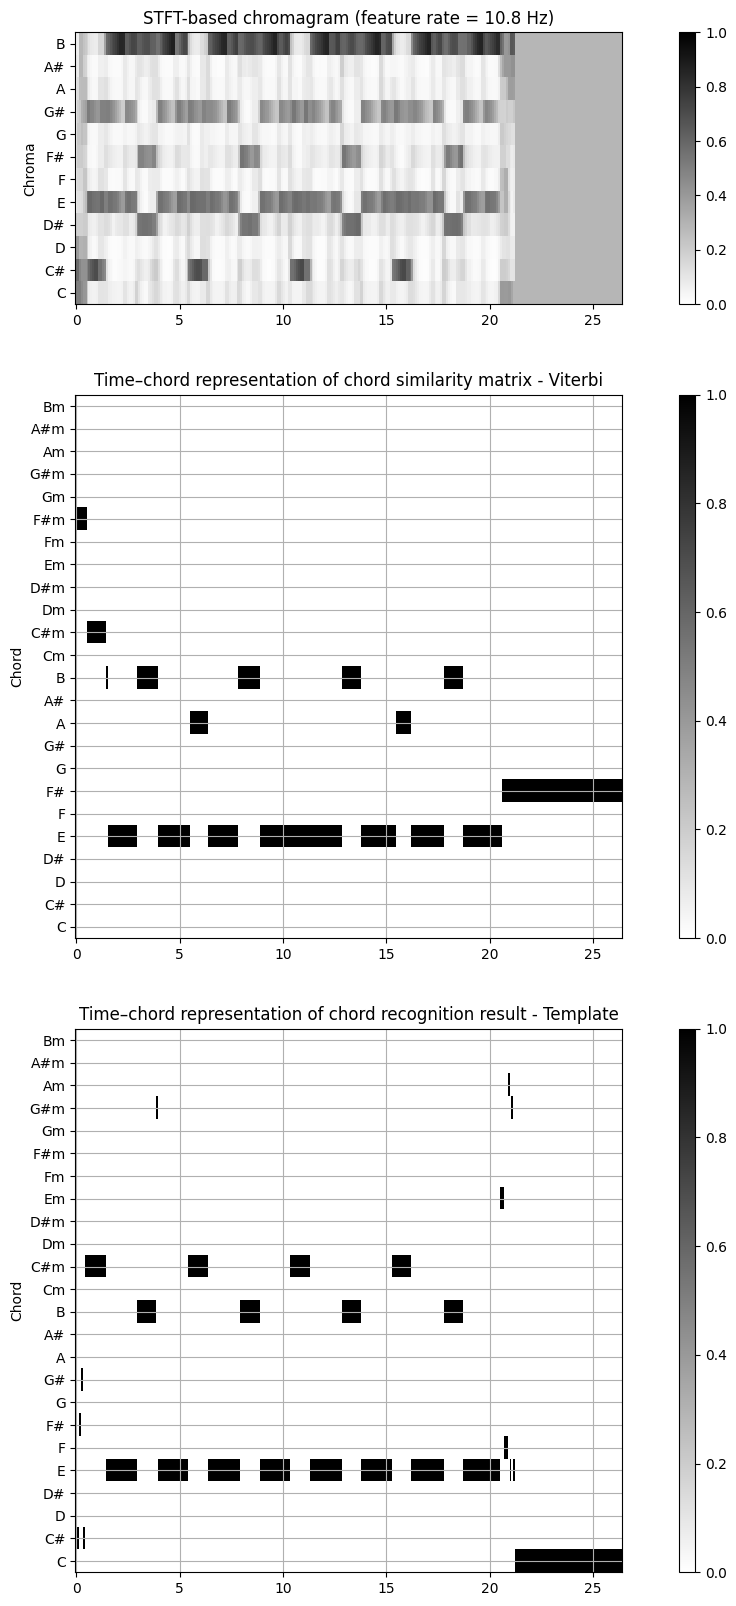

In [172]:
# Chord recognition
B_O, _ = tm.chord_recognition_template(X_CQT_median,nonchord=False, norm_sim='max')
C = 1/24 * np.ones((1,24))
A = A_comb

chord_viterbi, _, _, _ = hmm.viterbi_log_likelihood(A, B_O=B_O, C=C)

chord_sim, chord_max = tm.chord_recognition_template(X_CQT_median,nonchord=False, norm_sim='max')

## Plot Results ##

chord_labels_hmm = tm.get_chord_labels(nonchord=False)

fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1.5, 3, 3]}, figsize=(8, 20))
libfmp.b.plot_chromagram(X_CQT_median, ax=[ax[0,0], ax[0,1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))

libfmp.b.plot_matrix(chord_viterbi, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord similarity matrix - Viterbi',
                     ylabel='Chord', xlabel='')
ax[1, 0].set_yticks(np.arange( len(chord_labels_hmm) ))
ax[1, 0].set_yticklabels(chord_labels_hmm)
ax[1, 0].grid()

libfmp.b.plot_matrix(chord_max, ax=[ax[2, 0], ax[2, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord recognition result - Template',
                     ylabel='Chord', xlabel='')
ax[2, 0].set_yticks(np.arange( len(chord_labels_hmm) ))
ax[2, 0].set_yticklabels(chord_labels_hmm)
ax[2, 0].grid()
plt.show()
